Name: Minh T. Nguyen

Future Scientist Program - ACC - DoWhy Package

Estimating the Effect of a Member Rewards Program

### Credits:

1. This Algorithms: https://github.com/microsoft/dowhy/blob/master/docs/source/example_notebooks/dowhy_example_effect_of_memberrewards_program.ipynb

2. CI tutorial: https://github.com/amit-sharma/causal-inference-tutorial/tree/master/python

3. Other Application: https://microsoft.github.io/dowhy/example_notebooks/tutorial-causalinference-machinelearning-using-dowhy-econml.html#Why-causal-inference?

4. Package: https://microsoft.github.io/dowhy/

5. Paper: https://paperswithcode.com/paper/dowhy-an-end-to-end-library-for-causal


###1. Abstract: 
*The DoWhy package can be used to estimate the effect of a subscription or  rewards program for customers

*Suppose that Target has a membershp rewards program where customers receive additional benefits if they sign up. We want to know if the program is effective. 

###-> What is the impact of offering the membership rewards program on the total sales?
###-> If the current members had not signed up for the program, how much less would they have spent on the websites?

*This is the problem related to Average Treatment Effect on the Treated (ATT)

###2. Formulating the Causal Model

The rewarding program of Target was introduced in Jan 2019. The features are data of all monthly transactions of every user and on the time of singup for those who chose to signup for the rewards program. 

In [ ]:
# Creating some simulated data for the example
import pandas as pd
import numpy as np

num_users = 10000
num_months = 12

# Create tuples of users and signup months
signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2,size=num_users)

# Generating table of dataset
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup months == 0 means that the customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
    })

# Assigning a treatment value based on the signup month. If not signup then the treatment is False, else True
df["treatment"] = (1-(df["signup_month"]==0)).astype(bool)

# Simulating effect of month (monotonically increasing - customers buy the most in December)
df["spend"] = df["spend"] - df["month"]*10

# The Treatment Effect (simulating a simple treatment effect of 100)
after_signup = (df["signup_month"] < df["month"]) & (df["signup_month"] !=0)
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100

df

,user_id,signup_month,month,spend,treatment
0,0,10,1,483,True
1,0,10,2,512,True
2,0,10,3,464,True
3,0,10,4,466,True
4,0,10,5,456,True
...,...,...,...,...,...
119995,9999,5,8,496,True
119996,9999,5,9,516,True
119997,9999,5,10,511,True
119998,9999,5,11,480,True


###3. The Consideration on Time

*Time plays a crucial role in modeling this problem. Why? Rewards signup can affect the future transactions, but not those that happened before it. In fact, the transaction prior to the rewards signup can be assumed to CAUSE the rewards signup decision. Thus, we can split up the variables for each user in term of 

(1) Activity prior to the treatment (causes the treatment) - the signup program

(2) Activity after the treatment (is the outcome of applying treatmennt) - the signup program

HERE, many important variables that affect signup and total spend are missing (e.g., the type of products bought, length of a user's account, geography, etc.). So we'll need a node denoting Unobserved Confounders.

In [ ]:
!pip install dowhy

In [ ]:
import os, sys
sys.path.append(os.path.abspath("../../../"))
import dowhy

# Setting the signup month (for ease of analysis)
i = 6

      user_id  signup_month  treatment  pre_spends  post_spends
0           1             6       True       482.6   515.833333
1           2             0      False       469.4   385.666667
2           3             6       True       465.2   510.166667
3           4             0      False       460.0   404.000000
4           5             0      False       457.6   416.166667
...       ...           ...        ...         ...          ...
5507     9993             0      False       472.6   401.500000
5508     9994             0      False       466.0   408.500000
5509     9996             6       True       487.6   504.000000
5510     9997             6       True       471.8   509.666667
5511     9998             0      False       470.0   416.333333

[5512 rows x 5 columns]


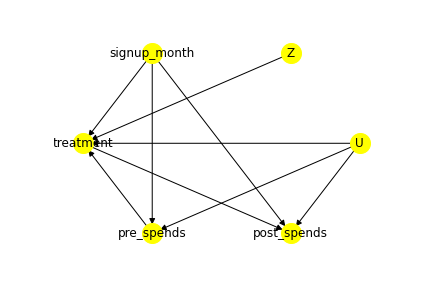

In [ ]:
causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
U[label="Unobserved Confounders"]; 
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends; signup_month->pre_spends;
signup_month->treatment;
U->treatment; U->pre_spends; U->post_spends;
}"""

# Post-process the data based on the graph and the month of the treatment (sign up program)
df_i_signupmonth = df[df.signup_month.isin([0,i])].groupby(["user_id", "signup_month", "treatment"]).apply(
    lambda x: pd.Series({'pre_spends': np.sum(np.where(x.month < i, x.spend,0))/np.sum(np.where(x.month<i, 1,0)),
                        'post_spends': np.sum(np.where(x.month > i, x.spend,0))/np.sum(np.where(x.month>i, 1,0)) })
    ).reset_index()

print(df_i_signupmonth) # Reprint the updated table

model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")

# model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

###4. Identifying the Causal Effect

For simplicy, says we assume that unobserved confounding does not play a big part

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                        
────────────(Expectation(post_spends|signup_month,pre_spends))
d[treatment]                                                  
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,pre_spends,U) = P(post_spends|treatment,signup_month,pre_spends)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(post_spends, [Z])*Derivative([treatment], [Z])**(-1))
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{treatment}, then ¬({Z}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Based on the graph, DoWhy determines that the signup month and amount spent in the pre-treatment months (signup_months, pre_spend) need to be conditioned on

### 5. Estimating the effect

We now estimate the effect based on the backdoor estimate, setting the targe units to "att"


In [ ]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor1.propensity_score_matching",
                                target_units="att")
print(estimate)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: post_spends~treatment+signup_month+pre_spends
Target units: att

## Estimate
Mean value: 103.72095671981776



###What does these feedback means?

*The analysis tell us the Average Treatmetn Effect on the Treated (ATT). That is, the average effect on the total spend for the customers that signed up for the Rewarding Program in month i=6 (compared to the case where they had not signed up). 

*Note: We can similarly calculalte the effect for customers who signed up in any other month by changing the value i = 6

*Note that the estimation suffers from left and right-censoring

1. Left-censoring: If the customer signs up in the first month, we do not have enough transaction history to match them to similar customers who did not sign up (and thus apply the backdoor identified estimation)

2. Right-censoring: if the customer signs up in the lastmonth, we do not have enought future (post-treatment) transactions to estimate the outcocme after sing up.

*Thus, even if the effect of signup was the same across all months, the estimated effects may be different by month of signup, due to lack of data (and thus high variance in estimated pre-treatment or post-treatment transactions activity).

### 6. Refuting the estimate:

*We refute the estimate using the placebo treatment refuter. This refuter substitutes the treatment by an independent random variable and checks whether our estimate now goes to zero

In [ ]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=2)
print(refutation)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a Placebo Treatment
Estimated effect:103.72095671981776
New effect:0.6421791951404714
p value:0.11916793187897057

